# Generating synthetic sequences with embedded regulatory grammars for RNA-binding proteins

### Motivation

This notebook discusses how to generate sequences with a simple set of motifs implanted in position specific locations.  The complexity of the number of motifs along a given sequence is pre-determined by the desired regulatory grammar complexity.  There are only positive grammars in each sequence, which basically means that there is no biological noise. This is an overly simplisitic data set with no biological noise and no positional noise, i.e. only sampling noise from the position weight matrices.  

### Simulation overview

To generate regulatory grammars, we first create a framework for the interactions of specific motifs across distinct spatial distances. We first create $M$ motifs, of which, we can generate $G$ regulatory grammars, which sample different combinations of the $M$ motifs with specific positions along the genome.  The specific positions between each motif is set by sampling an exponential distribution. Once the motif distances and combinations have been set, these constitute the set of regulatory grammars. Each regulatory grammar is associated to a given class.    

We can also simulate negative results by simulating different motifs with the same distances or the same motifs with different distance or incomplete grammars.  But here, we'll just assume a perfect dataset and see how it performs.  Later, we can systematically increase the complexity to monitor the performance of this model.  

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import scipy.misc 
%matplotlib inline
from scipy.misc import imresize
from six.moves import cPickle

#### Create a motif database for drosophila melanogaster

The motifs comes from Ray et al. "A compendium of RNA-binding motifs for decoding gene regulation" (http://www.nature.com/nature/journal/v499/n7457/abs/nature12311.html). The link to the motifs is here: 

!wget http://hugheslab.ccbr.utoronto.ca/supplementary-data/RNAcompete_eukarya/top10align_motifs.tar.gz

!tar xzvf top10align_motifs.tar.gz

Here, each file is a different RBP motif as a position frequency matrix.  So, the first step is to compile all of these files into a suitable database.  We can parse each motifs (position frequency matrix) from each file in motifpath (downloaded top10align_motifs folder), create a database (list of arrays), and save as binary format (motif.pickle):

In [2]:
# load motifs
motiflist = 'motif.pickle'  
if os.path.isfile(motiflist):

    # load motif list from file
    f = open(motiflist, 'rb')
    motif_set = cPickle.load(f)
    f.close()

else:
    # download motifs
    motifpath = 'top10align_motifs/'   # directory where motif files are located

    # get all motif files in motifpath directory
    listdir = os.listdir(motifpath)

    # parse motifs
    motif_set = []
    for files in listdir:
        df = pd.read_table(os.path.join(motifpath,files))
        motif_set.append(df.iloc[0::,1::].transpose())

    # save motifs    
    f = open(motiflist, 'wb')
    cPickle.dump(motif_set, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

## Model

There are a total of 244 motifs in the compendium. We can sample different sized subsets of these to create different levels of dataset complexity.  

$N$: total number of sequences 

$M$: total number of motifs ($M \leq 244$) 

$S$: size of each sequence (# nt per sequence)

$w$: population fraction of each regulatory grammar 

For simplicity, we will use a uniform distribution for the PWFs for all 'non-motif' nucleotides, i.e. $p = 1/4$.


Let's set up a hierarchical interaction model for the motifs, a so-called "regulatory grammar". For each grammar, we need to determine the number of motifs, which motifs, and their specific positions along the sequence.  Using this, we can then create a position frequency matrix of this regulatory grammar and simulate sequences the extent of which is determined by its population fraction $w$. 

In [3]:
from six.moves import cPickle
import numpy as np

def generate_grammar_model(options):
    """generate a regulatory grammar model: various numbers of motifs with 
    distinct separations."""

    # input options
    motif_set = options[0]   # set of all motifs
    num_motif = options[1]           # number of motifs for data set (to sample from motif_set)
    num_grammar = options[2]           # number of regulatory grammars (combinations of motifs)
    interaction_rate = options[3]  # exponential rate of number of motifs for each grammar
    distance_scale = options[4]    # exponential rate of distance between motifs
    distance_offset = options[5]   # offset addition between motif distances
    max_motif = options[6]         # maximum number of motifs in a grammar

    # select M random motifs from the complete list of motif_set
    motifIndex = np.random.permutation(len(motif_set))[0:num_motif]

    # build subset of motifs relevant for dataset
    motifs = []
    for index in motifIndex:
        motifs.append(motif_set[index])
    
    # generate G regulatory grammars (combinations of motifs + distance between motifs)
    Z = np.ceil(np.random.exponential(scale=interaction_rate, size=num_grammar)).astype(int)
    num_interactions = np.minimum(Z, max_motif)
    grammar = []
    distance = []
    for num in num_interactions:
        index = np.random.randint(num_motif, size=num)
        grammar.append(index)
        separation = np.ceil(np.random.exponential(scale=distance_scale, size=num)).astype(int) + distance_offset
        distance.append(separation)

    return [motifs, grammar, distance]


def generate_sequence_pwm(seq_length, gram, dist, motifs):
    """generates the position weight matrix (pwm) for a given regulatory grammar 
    with a string length S"""
    
    # figure out offset after centering grammar
    offset = np.round(np.random.uniform(1,(seq_length - np.sum(dist) - len(dist)*8 - 20)))

    # build position weight matrix
    sequence_pwm = np.ones((4,offset))/4
    for i in xrange(len(gram)):
        sequence_pwm = np.hstack((sequence_pwm, motifs[gram[i]]))
        if i < len(dist):
            sequence_pwm = np.hstack((sequence_pwm, np.ones((4,dist[i]))/4))

    # fill in the rest of the sequence with uniform distribution to have length seq_length
    sequence_pwm = np.hstack((sequence_pwm, np.ones((4,seq_length - sequence_pwm.shape[1]))/4))
    
    return sequence_pwm


def generate_sequence_model(seq_length, model):
    """generate the sequence models (PWMs) for each regulatory grammars. """
    
    motifs = model[0]      # set of motifs
    grammar = model[1]     # set of combinations of motifs
    distance = model[2]    # set of distances between motifs

    # build a PWM for each regulatory grammar
    seq_model = []
    for j in xrange(len(grammar)):
        seq_model.append(generate_sequence_pwm(seq_length, grammar[j], distance[j], motifs)) 
        
    return seq_model


def simulate_sequence(sequence_pwm):
    """simulate a sequence given a sequence model"""
    
    nucleotide = 'ACGU'

    # sequence length
    seq_length = sequence_pwm.shape[1]

    # generate uniform random number for each nucleotide in sequence
    Z = np.random.uniform(0,1,seq_length)
    
    # calculate cumulative sum of the probabilities
    cum_prob = sequence_pwm.cumsum(axis=0)

    # go through sequence and find bin where random number falls in cumulative 
    # probabilities for each nucleotide
    sequence = ''
    for i in xrange(seq_length):
        index=[j for j in xrange(4) if Z[i] < cum_prob[j,i]][0]
        sequence += nucleotide[index]

    return sequence


def simulate_data(seq_model, num_seq):
    """simulates N sequences with random population fractions for each sequence 
    model (PWM) of each regulatory grammar """

    # simulate random population fractions and scale to N sequences
    w = np.random.uniform(0, 1, size=len(seq_model))
    w = np.round(w/sum(w)*num_seq)
    popFrac = w.astype(int)
    
    # create a popFrac weighted number of simulation for each regulatory grammar
    label = []
    data = []
    for i in xrange(len(popFrac)):
        for j in xrange(popFrac[i]):
            sequence = simulate_sequence(seq_model[i])
            data.append(sequence)
            label.append(i)
            
    return data, label


def convert_one_hot(seq):
    """convert a sequence into a 1-hot representation"""
    
    nucleotide = 'ACGU'
    N = len(seq)
    one_hot_seq = np.zeros((4,N))
    for i in xrange(200):         
        #for j in range(4):
        #    if seq[i] == nucleotide[j]:
        #        one_hot_seq[j,i] = 1
        index = [j for j in xrange(4) if seq[i] == nucleotide[j]]
        one_hot_seq[index,i] = 1
        
    return one_hot_seq


def subset_data(data, label, sub_index):
    """returns a subset of the data and labels based on sub_index"""
    
    num_labels = len(np.unique(label))
    num_sub = len(sub_index)
    
    sub_set = np.zeros((num_sub, 4, len(data[0])))
    sub_set_label = np.zeros((num_sub, num_labels))
    
    k = 0;
    for index in sub_index:
        sub_set[k] = convert_one_hot(data[index])
        sub_set_label[k,label[index]] = 1
        k += 1

    sub_set_label = sub_set_label.astype(np.uint8)
    
    return (sub_set, sub_set_label)


def split_data(data, label, split_size):
    """split data into train set, cross-validation set, and test set"""
    
    # number of labels
    num_labels = len(np.unique(label))

    # determine indices of each dataset
    N = len(data)
    cum_index = np.cumsum(np.multiply([0, split_size[0], split_size[1], split_size[2]],N)).astype(int) 

    # shuffle data
    shuffle = np.random.permutation(N)

    # training dataset
    train_index = shuffle[range(cum_index[0], cum_index[1])]
    cross_validation_index = shuffle[range(cum_index[1], cum_index[2])]
    test_index = shuffle[range(cum_index[2], cum_index[3])]

    # create subsets of data based on indices 
    train = subset_data(data, label, train_index)
    cross_validation = subset_data(data, label, cross_validation_index)
    test = subset_data(data, label, test_index)
    
    return train, cross_validation, test



In [7]:

# dataset parameters
num_seq = 300000       # number of sequences
seq_length = 200       # length of sequence
num_motif = 20         # number of motifs
num_grammar =20       # number of regulatory grammars
filename =  'N=' + str(num_seq) + \
            '_S=' + str(seq_length) + \
            '_M=' + str(num_motif) + \
            '_G=' + str(num_grammar) # output filename

# motif interaction parameters (grammars)
interaction_rate = 1.5       # exponential rate of number of motifs for each grammar
distance_scale = seq_length/15        # exponential rate of distance between motifs
offset = 5                   # offset addition between motif distances
maxMotif = 5                 # maximum number of motifs in a grammar

# percentage for each dataset
train_size = 0.7
cross_validation_size = 0.15
test_size = 0.15

# load motif list from file
motiflist = 'motif.pickle'
f = open(motiflist, 'rb')
motif_set = cPickle.load(f)
f.close()

# generate regulatory grammar model
print "Generating motif grammars"
options = [motif_set, num_motif, num_grammar, 
        interaction_rate, distance_scale, offset, maxMotif]
model = generate_grammar_model(options)

# convert this to a sequence position weight matrix for each model
seq_model = generate_sequence_model(seq_length, model)

# simulate N sequences based on the position weight matrices
print "Generating synthetic data"
data, label = simulate_data(seq_model, num_seq)


Generating motif grammars
Generating synthetic data


We can visualize the grammars in PWM forms using sequence logos.  

In [8]:

def seq_logo(pwm, height=100, width=200, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                correction = 3/2
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
            
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)

    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    nt_width = np.floor(width/num_seq).astype(int)
    logo = np.ones((height, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = height;
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        
        for j in range(num_nt):
            # resized dimensions of image
            if nt_height[j] > 0:
                resize = (nt_height[j],nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                for k in range(3):
                    for m in range(len(width_range)):
                        logo[height_range, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


def plot_conv_filter(plt, pwm, height=200, bp_width=100, norm=0, rna=1, adjust=-1, filepath='.', showbar=0):
    num_seq = pwm.shape[1]
    width = bp_width*num_seq

    logo = seq_logo(pwm, height, width, norm, rna, filepath)
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].imshow(logo, extent=[bp_width*2, width+bp_width, 0, height])
    axes[0].set_axis_off()
    im = axes[1].imshow(pwm, cmap='jet', vmin=0, vmax=1, interpolation='none') 
    axes[1].set_axis_off()
    fig.subplots_adjust(bottom=adjust)
    if showbar == 1:
        cbar_ax = fig.add_axes([.85, 0.05, 0.05, 0.45])
        cb = fig.colorbar(im, cax=cbar_ax, ticks=[0, 0.5, 1])
        cb.ax.tick_params(labelsize=16)
    return fig

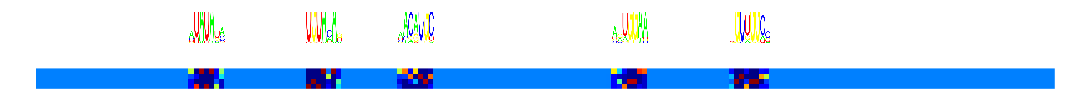

In [10]:
index = 1
pwm = seq_model[index]
seq_length = pwm.shape[1]
plt.figure(figsize = (4,2))
fig = plot_conv_filter(plt, pwm, height=600, bp_width=100, norm=0, rna=1, adjust=-.9, filepath='.', showbar=0)
fig.set_size_inches(15,4, forward=True) 
plt.savefig('seq_model_'+ str(index) +'.eps', format='eps', dpi=200)

Now that we generated some simulated data, we should shuffle the data, then split the data into training set, cross-validation set, and test set, while converting the sequence data into one-hot representation.

In [11]:

# get indices for each dataset
print "Splitting dataset into train, cross-validation, and test"
split_size = [train_size, cross_validation_size, test_size]
train, cross_validation, test = split_data(data, label, split_size)

# save training dataset in one-hot representation
print "Saving dataset"
f = open(filename+'_data.pickle', 'wb')
cPickle.dump(train, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(cross_validation, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(test, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

# save training dataset in one-hot representation
print "Saving model"
f = open(filename+'_model.pickle', 'wb')
cPickle.dump(options, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(model, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(seq_model, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()


Splitting dataset into train, cross-validation, and test
Saving dataset
Saving model


In [12]:
filename

'N=300000_S=200_M=20_G=20'